In [2]:
# Importing necessary library files
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import math

## Activation Functions

In [3]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A,Z

In [4]:
def relu(Z):
    A = np.maximum(0,Z)
    return A,Z

## Parameter Initialization

In [5]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    num_layers= len(layer_dims)
    parameters = {}
    
    for l in range(1,num_layers):
        parameters["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters["b"+str(l)] = np.zeros((layer_dims[l],1))
    
    return parameters

## Mini-batch Gradient Descent

## Random Minibatches Generation

In [26]:
def random_minibatches(X,Y,mini_batch_size,seed):
    np.random.seed(seed)
    minibatches = []
    m = X.shape[1]
    
    permutation = list(np.random.permutation(m))
    X_shuffled = X[:,permutation]
    Y_shuffled = Y[:,permutation]
    
    num_minibatches = math.floor(m/mini_batch_size)
    
    for i in range(0,num_minibatches):
        X_minibatch = X_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        Y_minibatch = Y_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch = (X_minibatch,Y_minibatch)
        minibatches.append(mini_batch)
        
    if m%mini_batch_size!=0:
        X_minibatch = X_shuffled[:,num_minibatches*mini_batch_size:m]
        Y_minibatch = Y_shuffled[:,num_minibatches*mini_batch_size:m]
        mini_batch = (X_minibatch,Y_minibatch)
        minibatches.append(mini_batch)
        
    return minibatches

## Adam Optimization

In [7]:
def initialize_adam(parameters):
    v = {}
    s = {}
    L = len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return v,s

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon):
    L = len(parameters)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW"+str(l+1)] = beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]
        v_corrected["dW"+str(l+1)] = v["dW"+str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db"+str(l+1)] = v["db"+str(l+1)]/(1-np.power(beta1,t))
        
        s["dW"+str(l+1)] = beta2*s["dW"+str(l+1)]+(1-beta2)*np.square(grads["dW"+str(l+1)])
        s["db"+str(l+1)] = beta2*s["db"+str(l+1)]+(1-beta2)*np.square(grads["db"+str(l+1)])
        s_corrected["dW"+str(l+1)] = s["dW"+str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db"+str(l+1)] = s["db"+str(l+1)]/(1-np.power(beta2,t))
        
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*v_corrected["dW"+str(l+1)]/(np.sqrt(s_corrected["dW"+str(l+1)])+epsilon)
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*v_corrected["db"+str(l+1)]/(np.sqrt(s_corrected["db"+str(l+1)])+epsilon)
        
    return parameters,v,s

## Forward Propagation

In [9]:
def linear_forward(A_prev,W,b):
    Z = np.dot(W,A_prev)+b
    linear_cache = (A_prev,W,b)
    
    return(Z,linear_cache)

In [10]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if activation=="sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation=="relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
        
    cache = (linear_cache,activation_cache)
    
    return A,cache

In [11]:
def L_model_forward(X,parameters):
    #print(type(parameters))
    #print(len(parameters))
    #print(parameters)
    A = X
    caches = []
    L = len(parameters)//2
    
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation="relu")
        caches.append(cache)
    AL,cache = linear_activation_forward(A,parameters["W"+str(l+1)],parameters["b"+str(l+1)],activation="sigmoid")
    caches.append(cache)
    
    return AL,caches

## Compute Cost

In [12]:
def compute_cost(AL,Y,parameters,lambd):
    m = Y.shape[1]
    cross_entropy_cost = np.sum(np.multiply(Y,np.log(AL))+np.multiply((1-Y),(np.log(1-AL))))/(-m)
    theta_sum = 0
    L = len(parameters)//2
    
    for l in range(L):
        theta_sum += np.sum(np.square(parameters["W"+str(l+1)]))
    
    L2_reg_cost = (1/m)*(lambd/2)*theta_sum
    cost = cross_entropy_cost+L2_reg_cost
    
    return cost

## Backward Propagation

In [13]:
def linear_backward(dZ,linear_cache, lambd):
    A_prev,W,b = linear_cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ,A_prev.T)/m + (lambd/m)*W
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev,dW,db

In [14]:
def linear_activation_backward(dA, cache, lambd, activation):
    linear_cache, activation_cache = cache
    Z = activation_cache
    
    if activation =="sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        dA_prev, dW, db = linear_backward(dZ,linear_cache, lambd)
    elif activation =="relu":
        dZ = np.array(dA, copy=True)
        dZ[Z<=0] = 0
        dA_prev, dW, db = linear_backward(dZ,linear_cache, lambd)
            
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL,Y,caches,lambd):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y,AL)-np.divide((1-Y),(1-AL)))
    
    current_cache = caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,lambd,activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,lambd, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

## Updating Parameters

In [16]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate* grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate* grads["db"+str(l+1)]
    return parameters

## DNN Model Main Function

In [24]:
def dnn_model(X,Y,layer_dims,num_epochs,learning_rate,optimizer='gd',lambd=0,mini_batch_size=64,beta1=0.9,beta2=0.999,epsilon=1e-8):
    
    #print(type(parameters))
    #print(len(parameters))
    #print(parameters)
    seed = 10
    costs = []
    t = 0
    m = X.shape[1]
    
    #parameter initialization
    parameters = initialize_parameters(layer_dims)
    
    if optimizer == 'gd':
        pass
    elif optimizer == 'adam':
        v,s = initialize_adam(parameters)
    
    #Model Training
    for epoch in range(0,num_epochs):
        seed = seed+1
        minibatches = random_minibatches(X,Y,mini_batch_size,seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (X_minibatch,Y_minibatch) = minibatch
            AL,caches = L_model_forward(X_minibatch,parameters)
            cost_total += compute_cost(AL,Y_minibatch,parameters,lambd)
            grads = L_model_backward(AL,Y_minibatch,caches,lambd)
            
            if optimizer == 'gd':
                parameters = update_parameters(parameters,grads,learning_rate)
            elif optimizer == 'adam':
                t = t+1
                parameters,v,s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        
        cost_avg = cost_total/m
        if epoch%100 == 0:
            print('Cost after iteration {}: {}'.format(epoch,cost_avg))
            costs.append(cost_avg)
            
    plt.plot(np.squeeze(costs))
    plt.xlabel('Number of iterations(hundred)')
    plt.ylabel('Cost')
    plt.title('Learning rate: '+str(learning_rate))
    plt.show()
    
    return parameters

## Prediction

In [18]:
def predict(X,parameters):
    
    AL,caches = L_model_forward(X,parameters)
    predictions = (AL>0.5).astype(int)
    return predictions

In [19]:
def accuracy(pred,Y):
    m = pred.shape[1]
    #acc = np.sum((pred==Y)/m)*100
    acc = np.mean((pred[0,:] == Y[0,:]))
    return str(acc)

In [20]:
def plotting_boundary(model,X,Y):
    
    min_x,max_x = X[0,:].min()-0.25,X[0,:].max()+0.25
    min_y,max_y = X[1,:].min()-0.25,X[1,:].max()+0.25
    h = 0.01 # temp
    
    xx,yy = np.meshgrid(np.arange(min_x,max_x,h),np.arange(min_y,max_y,h))
    Z = model(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    #plt.figure(figsize=(10,5))
    plt.contourf(xx,yy,Z, cmap = plt.cm.Spectral)
    plt.scatter(X[0,:],X[1,:],c=Y[0,:], cmap = plt.cm.Spectral)
    plt.show()

## Testing with Datasets

In [21]:
# Loading Iris(local) Dataset
iris = pd.read_csv("Datasets/Iris/Iris/iris.csv")
iris.loc[iris["species"]=='virginica','species']=0
iris.loc[iris["species"]=='versicolor','species']=1
iris.loc[iris["species"]=='setosa','species']=2
iris = iris[iris['species']!=2]
#print(iris.head())
X = iris[['petal_length','petal_width']].values
Y = iris[['species']].values
Y = Y.astype('uint8')

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2, 80)
(1, 80)
(2, 20)
(1, 20)


Cost after iteration 0: 0.008664324731825037
Cost after iteration 100: 0.008664324464016358
Cost after iteration 200: 0.008664324190572423
Cost after iteration 300: 0.008664323911305803
Cost after iteration 400: 0.008664323626034545
Cost after iteration 500: 0.008664323334577706
Cost after iteration 600: 0.008664323036752557
Cost after iteration 700: 0.008664322732372793
Cost after iteration 800: 0.008664322421247334
Cost after iteration 900: 0.008664322103179514
Cost after iteration 1000: 0.008664321777966454
Cost after iteration 1100: 0.008664321445398604
Cost after iteration 1200: 0.0086643211052593
Cost after iteration 1300: 0.008664320757324403
Cost after iteration 1400: 0.008664320401361933
Cost after iteration 1500: 0.008664320037131716
Cost after iteration 1600: 0.008664319664385016
Cost after iteration 1700: 0.008664319282864163
Cost after iteration 1800: 0.008664318892302177
Cost after iteration 1900: 0.008664318492422354
Cost after iteration 2000: 0.008664318082937852
Cost a

Cost after iteration 17700: 0.008523484357841697
Cost after iteration 17800: 0.008488882908652044
Cost after iteration 17900: 0.008448456350077927
Cost after iteration 18000: 0.008402756276129079
Cost after iteration 18100: 0.008352329506046328
Cost after iteration 18200: 0.008297439543715882
Cost after iteration 18300: 0.0082380820151805
Cost after iteration 18400: 0.008174110827755796
Cost after iteration 18500: 0.008105293284596455
Cost after iteration 18600: 0.008031296671480531
Cost after iteration 18700: 0.007951657150691937
Cost after iteration 18800: 0.007865748521350607
Cost after iteration 18900: 0.007772748476176611
Cost after iteration 19000: 0.007671597592550958
Cost after iteration 19100: 0.00756094795933703
Cost after iteration 19200: 0.007439100180309202
Cost after iteration 19300: 0.007303930353402233
Cost after iteration 19400: 0.007152814678973296
Cost after iteration 19500: 0.006982571862474335
Cost after iteration 19600: 0.006789466785972813
Cost after iteration 19

Cost after iteration 34800: 0.0010320977258127478
Cost after iteration 34900: 0.0010313491120849897
Cost after iteration 35000: 0.001030614241352318
Cost after iteration 35100: 0.0010298958683176767
Cost after iteration 35200: 0.0010291844057349927
Cost after iteration 35300: 0.001028488814818811
Cost after iteration 35400: 0.0010278141029615938
Cost after iteration 35500: 0.0010271343329673805
Cost after iteration 35600: 0.0010264760119946125
Cost after iteration 35700: 0.0010258355408752566
Cost after iteration 35800: 0.0010251990597253072
Cost after iteration 35900: 0.0010245735224120836
Cost after iteration 36000: 0.0010239586538213343
Cost after iteration 36100: 0.0010233541875415788
Cost after iteration 36200: 0.0010227598654155698
Cost after iteration 36300: 0.001022175437155564
Cost after iteration 36400: 0.001021600660006756
Cost after iteration 36500: 0.001021035298447327
Cost after iteration 36600: 0.0010204791239166785
Cost after iteration 36700: 0.0010199319145656031
Cost 

Cost after iteration 51900: 0.0009826498087250855
Cost after iteration 52000: 0.0009825322551800888
Cost after iteration 52100: 0.000982415438819618
Cost after iteration 52200: 0.0009822993522297268
Cost after iteration 52300: 0.000982183988105617
Cost after iteration 52400: 0.0009820693392494923
Cost after iteration 52500: 0.0009819553985684457
Cost after iteration 52600: 0.0009818421590724134
Cost after iteration 52700: 0.0009817296138721638
Cost after iteration 52800: 0.0009816177561773553
Cost after iteration 52900: 0.0009815065792946076
Cost after iteration 53000: 0.000981396076625655
Cost after iteration 53100: 0.0009812862416655153
Cost after iteration 53200: 0.000981177068000716
Cost after iteration 53300: 0.000981068549307561
Cost after iteration 53400: 0.0009809606793504265
Cost after iteration 53500: 0.0009808534519801138
Cost after iteration 53600: 0.0009807468611322304
Cost after iteration 53700: 0.0009806409008256034
Cost after iteration 53800: 0.0009805355651607407
Cost 

Cost after iteration 68400: 0.0009699950366881208
Cost after iteration 68500: 0.0009699463175843446
Cost after iteration 68600: 0.000969897791285769
Cost after iteration 68700: 0.0009698494565964647
Cost after iteration 68800: 0.0009698013123317272
Cost after iteration 68900: 0.0009697533573178976
Cost after iteration 69000: 0.0009697055903922187
Cost after iteration 69100: 0.0009696580104026709
Cost after iteration 69200: 0.0009696106162078316
Cost after iteration 69300: 0.0009695634066767142
Cost after iteration 69400: 0.0009695163806886311
Cost after iteration 69500: 0.0009694695371330484
Cost after iteration 69600: 0.0009694228749094433
Cost after iteration 69700: 0.0009693763929271729
Cost after iteration 69800: 0.0009693300901053367
Cost after iteration 69900: 0.000969283965372641
Cost after iteration 70000: 0.0009692380176672758
Cost after iteration 70100: 0.0009691922459367879
Cost after iteration 70200: 0.0009691466491379506
Cost after iteration 70300: 0.0009691012262366459
Co

Cost after iteration 85400: 0.000963780680009519
Cost after iteration 85500: 0.0009637533222976172
Cost after iteration 85600: 0.0009637260449028614
Cost after iteration 85700: 0.0009636988474722236
Cost after iteration 85800: 0.0009636717296547536
Cost after iteration 85900: 0.0009636446911015604
Cost after iteration 86000: 0.0009636177314657945
Cost after iteration 86100: 0.0009635908504026291
Cost after iteration 86200: 0.000963564047569257
Cost after iteration 86300: 0.0009635373226248651
Cost after iteration 86400: 0.0009635106752306246
Cost after iteration 86500: 0.0009634841050496721
Cost after iteration 86600: 0.0009634576117471035
Cost after iteration 86700: 0.0009634311949899509
Cost after iteration 86800: 0.000963404854447171
Cost after iteration 86900: 0.0009633785897896326
Cost after iteration 87000: 0.000963352400690103
Cost after iteration 87100: 0.0009633262868232295
Cost after iteration 87200: 0.0009633002478655363
Cost after iteration 87300: 0.0009632742834953937
Cost

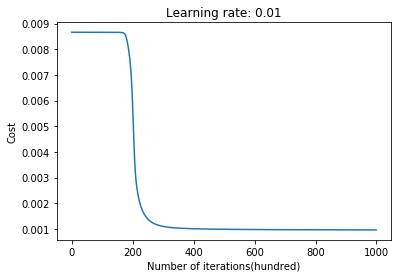

{'W1': array([[ 4.46021516e-01,  1.14078337e+00],
       [ 9.64974681e-04, -1.86349270e-02],
       [-2.77388203e-03, -3.54758979e-03],
       [-8.27414815e-04, -6.27000677e-03],
       [-4.38181690e-04, -4.77218030e-03],
       [-1.31386475e-02,  8.84622380e-03]]), 'b1': array([[-2.96331389],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]]), 'W2': array([[ 2.03968650e+00,  1.70957306e-02,  5.00336422e-04,
        -4.04677415e-03, -5.45359948e-03, -1.54647732e-02],
       [ 2.26695545e+00, -1.10106763e-02, -1.18504653e-02,
        -2.05649899e-03,  1.48614836e-02,  2.36716267e-03],
       [-1.02378514e-02, -7.12993200e-03,  6.25244966e-03,
        -1.60513363e-03, -7.68836350e-03, -2.30030722e-03],
       [ 9.90671160e-01,  1.97611078e-02, -1.24412333e-02,
        -6.26416911e-03, -8.03766095e-03, -2.41908317e-02]]), 'b2': array([[-1.29951596],
       [-1.4443114 ],
       [ 0.        ],
       [-0.63117117]]), 'W3': array([

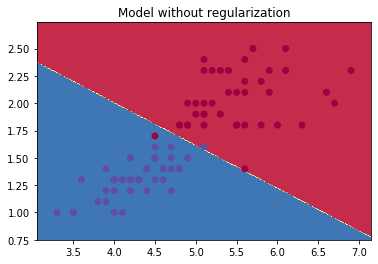

In [39]:
# Declaring Hyperparameters and Training DNN

learning_rate = 0.01
num_epochs = 100000
layer_dims = [2,6,4,1]
lambd = 0

parameters = dnn_model(X_train,Y_train,layer_dims,num_epochs,learning_rate,optimizer='gd',mini_batch_size=80)
#print(len(parameters))
print(parameters)

#plotting_boundary(lambda x: predict(x.reshape(X.shape[0],x.shape[0]),parameters),X,Y)
plt.title("Model without regularization")
#axes = plt.gca()
#axes.set_xlim([-0.75,0.40])
#axes.set_ylim([-0.75,0.65])
plotting_boundary(lambda x: predict(x.T,parameters), X_train, Y_train)

In [41]:
# Predictions, Train and Test Accuracy
pred = predict(X_train,parameters)
#print(pred.shape)
train_accu = accuracy(pred,Y_train)
test_pred = predict(X_test,parameters)
test_accu = accuracy(test_pred,Y_test)
print(train_accu)
print(test_accu)

0.9625
0.85
